## **DSIP Project Python Notebook File**
### **Title : Pneumonia Detection using Chest X-Ray Images**

**Course Name**: Digital Signal & Image Processing

**Group Members**:
- Kaustubh Wagh [202201070021]
- Apoorva Singh [202201070030]
- Yash Sawant [202201070032]

---

**Abstract**<br>
This project presents a classical approach to pneumonia detection using chest X-ray images, avoiding deep CNNs and instead relying on image processing and a simple Artificial Neural Network (ANN). The pipeline includes grayscale conversion, image enhancement, thresholding, contour-based shape analysis, and texture feature extraction using Gray Level Co-occurrence Matrix (GLCM). The extracted features are used to train traditional machine learning models and an ANN. The ANN demonstrated competitive performance, highlighting the effectiveness of combining handcrafted features with lightweight neural architectures for medical image classification.

---
**Problem Statement**<br>
To develop a pneumonia detection system using classical image processing techniques and a simple Artificial Neural Network (ANN) for classifying chest X-ray images based on extracted shape and texture features.

---
**Objectives**
- To apply classical image processing techniques for feature extraction from chest X-ray images.

- To extract shape-based and texture-based features relevant to pneumonia detection.

- To train and evaluate traditional ML models and a simple ANN using the extracted features.

- To compare the performance of the ANN with other machine learning models.

- To demonstrate an efficient, lightweight alternative to deep CNNs for medical image classification.


---
---




# **1. Dataset Collection & Understanding**

Source: [Kaggle - Chest X-ray Images (Pneumonia)](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia)


### **1.1 Uploading `kaggle.json` for API Access**

This step allows you to upload the `kaggle.json` file, which contains your Kaggle API credentials. This file is necessary for authenticating and accessing datasets directly from Kaggle using the API. Simply upload the file to Colab for use in subsequent steps.


In [ ]:
from google.colab import files
files.upload()  # Upload the kaggle.json file here

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kaustubhwagh17","key":"69b44e72d9300c0d2d3a864ace2b43a1"}'}

---
### **1.2 Setting Up Kaggle API Credentials**

In this step, we create a `.kaggle` directory in the home folder and copy the `kaggle.json` file into it. We then set the appropriate file permissions to ensure that the API key is securely readable only by the user. This setup enables the Kaggle API to function properly in your environment.


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

---
### **1.3 Downloading the Chest X-Ray Pneumonia Dataset**

This command uses the Kaggle API to download the "Chest X-Ray Images (Pneumonia)" dataset from Kaggle. The dataset will be stored as a ZIP file in the current working directory, which contains chest X-ray images for both normal and pneumonia classes.


In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


---
### **1.4 Unzipping the Downloaded Dataset**
This block of code unzips the "chest-xray-pneumonia.zip" file that was downloaded earlier. It extracts the contents into the current directory, specifically into a folder named "chest_xray". After extraction, it checks and lists the files inside the "chest_xray" directory to verify the extraction.


In [ ]:
import zipfile
import os

# Unziping the downloaded dataset
with zipfile.ZipFile("chest-xray-pneumonia.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

# Checking extracted contents
os.listdir("chest_xray")

['train', 'val', '__MACOSX', 'test', 'chest_xray']

---
### **1.5 Importing Libraries and Setting Seeds**
This block imports various essential libraries for image processing, machine learning, and deep learning. These include libraries for
- image handling (`cv2`, `numpy`, `matplotlib`),
- feature extraction (`skimage.feature`),
- machine learning (`sklearn`), and
- neural networks (`tensorflow.keras`).

Additionally, it sets random seeds for reproducibility across different runs of the code, ensuring that results are consistent when using random number generation.


In [ ]:
import os, random, zipfile
# image handling libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt

# feature extraction libraries
from skimage.feature import graycomatrix, graycoprops

# machine leanring libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# neural network libaries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# Set seed for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

---
### **1.6 Loading Training Images**
- Loads images from the "NORMAL" and "PNEUMONIA" directories.
- Creates two lists:
  - `sub_paths`: Contains paths to all the images.
  - `sub_labels`: Contains corresponding labels (0 for NORMAL, 1 for PNEUMONIA).
- Prints the total number of loaded images.


In [ ]:
normal_dir    = 'chest_xray/train/NORMAL'
pneumonia_dir = 'chest_xray/train/PNEUMONIA'

normal_imgs    = [os.path.join(normal_dir, f) for f in os.listdir(normal_dir)]
pneumonia_imgs = [os.path.join(pneumonia_dir, f) for f in os.listdir(pneumonia_dir)]

sub_paths  = normal_imgs + pneumonia_imgs
sub_labels = [0]*len(normal_imgs) + [1]*len(pneumonia_imgs)

print(f"  → Loaded {len(normal_imgs)} NORMAL and {len(pneumonia_imgs)} PNEUMONIA images (total {len(sub_paths)})\n")
print("  → Completed Step 1\n")

  → Loaded 1341 NORMAL and 3875 PNEUMONIA images (total 5216)

  → Completed Step 1



---
---
# **2: Image Processing Operations**
## **2.1 Image Fundamentals - Resizing and Histogram Visualization**
- **Resizes** images to 256x256 pixels for uniformity.
- For each selected image:
  - **Calculates** statistics (min, max, mean, standard deviation).
  - **Displays** the image and its histogram.
  - **Title** of each image includes its min/max values and statistical metrics.
- **Visualizes** histograms for image pixel intensity distribution.
- **Displays** 4 random image samples with corresponding histograms.



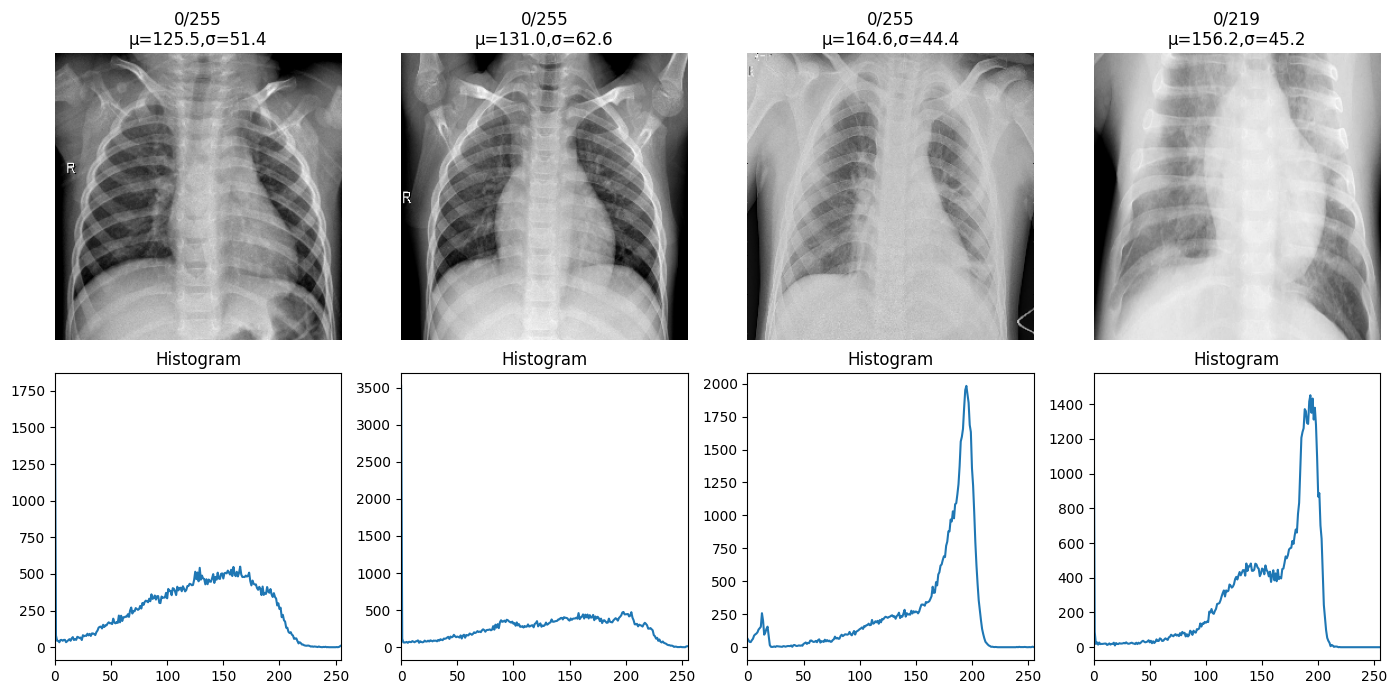

  → Completed Step 2.1



In [ ]:
target_size = (256, 256)
fig, axes = plt.subplots(2, 4, figsize=(14, 7))
for i, path in enumerate(random.sample(sub_paths, 4)):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img_rs = cv2.resize(img, target_size)
    h, _ = np.histogram(img_rs.ravel(), bins=256, range=(0,256))
    mn, mx, mean, std = img_rs.min(), img_rs.max(), img_rs.mean(), img_rs.std()
    axes[0,i].imshow(img_rs, cmap='gray')
    axes[0,i].set_title(f"{mn}/{mx}\nμ={mean:.1f},σ={std:.1f}")
    axes[0,i].axis('off')
    axes[1,i].plot(h)
    axes[1,i].set_xlim(0,255)
    axes[1,i].set_title("Histogram")
plt.tight_layout()
plt.show()
print("  → Completed Step 2.1\n")


---
## **2.2 Image Enhancement - Hist EQ, CLAHE and GAMMA**
- **Applies** various enhancement techniques to images:
  - **Histogram Equalization** for improved contrast.
  - **CLAHE (Contrast Limited Adaptive Histogram Equalization)** for localized contrast enhancement.
  - **Gamma Correction** for adjusting brightness and contrast.



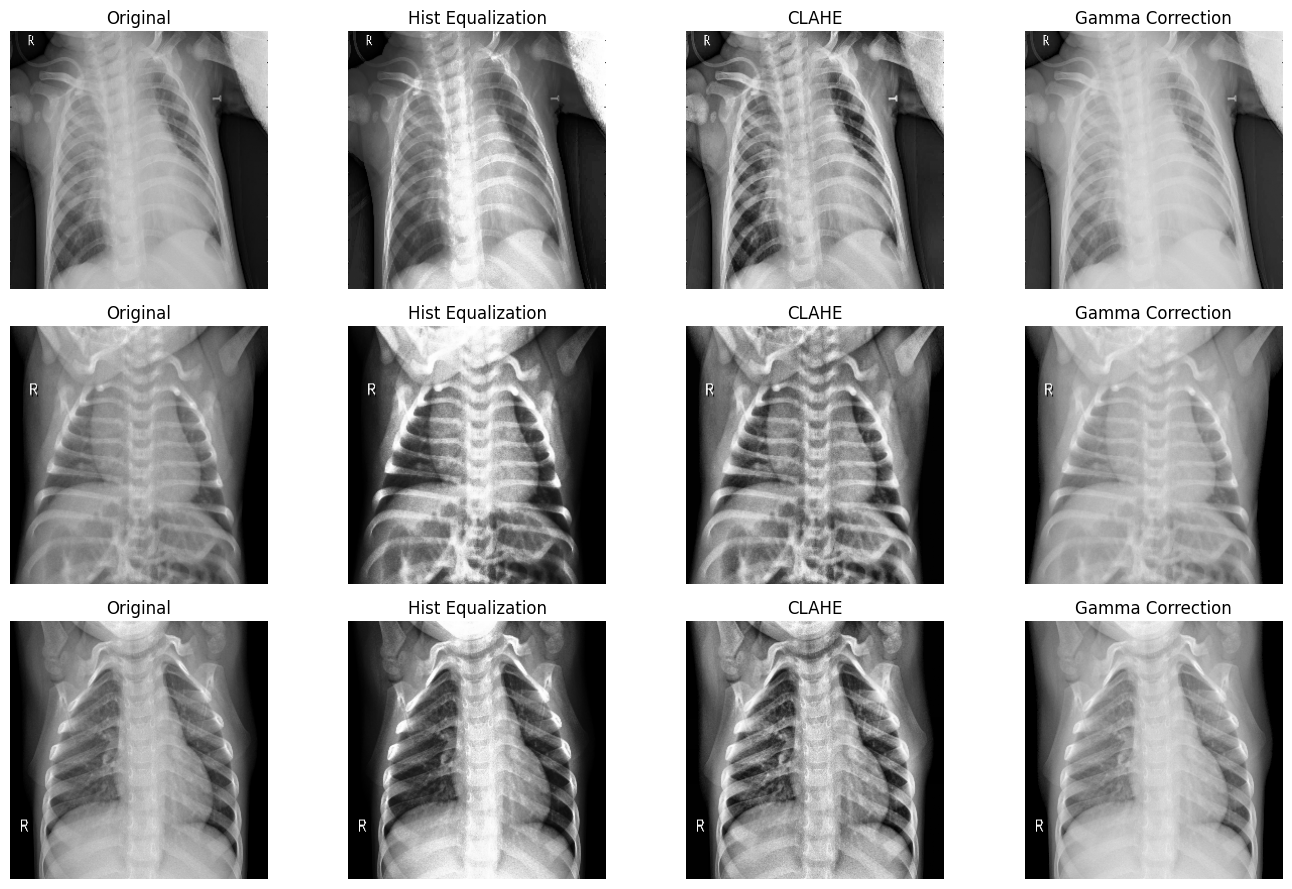

  → Completed Step 2.2



In [ ]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
def gamma_corr(img, g=1.5):
    table = np.array([((i/255.0)**(1.0/g))*255 for i in range(256)]).astype('uint8')
    return cv2.LUT(img, table)

fig, axes = plt.subplots(3, 4, figsize=(14,9))
for r, path in enumerate(random.sample(sub_paths, 3)):
    img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), target_size)
    variants = [
        img,
        cv2.equalizeHist(img),
        clahe.apply(img),
        gamma_corr(img)
    ]
    titles = ["Original", "Hist Equalization", "CLAHE", "Gamma Correction"]
    for c, v in enumerate(variants):
        axes[r, c].imshow(v, cmap='gray')
        axes[r, c].set_title(titles[c])
        axes[r, c].axis('off')
plt.tight_layout()
plt.show()
print("  → Completed Step 2.2\n")

---
# **2.3 Image Filtering - Gaussian Blur, Median and Sobel Edge**
- **Applies** 3 types of image filters to enhance features:
  - **Gaussian Blur** to reduce noise and detail.
  - **Median Filter** to remove salt-and-pepper noise.
  - **Sobel Edge Detection** to highlight edges.


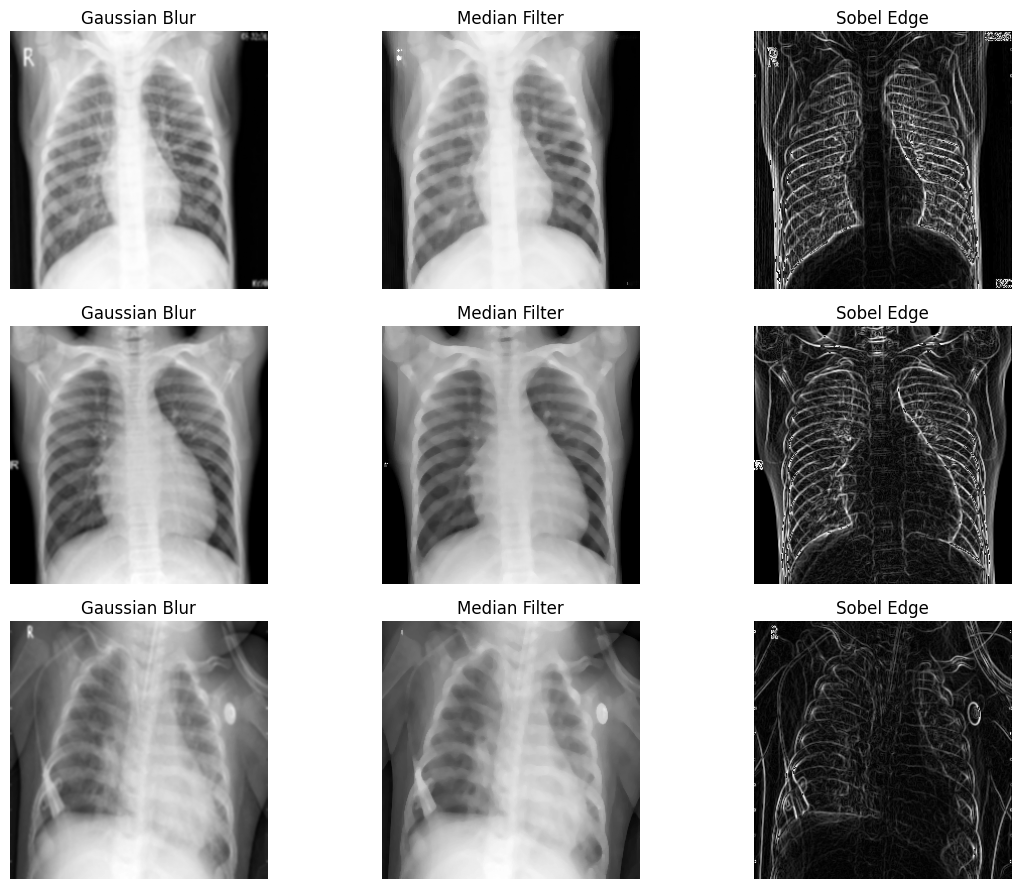

  → Completed Step 2.3



In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(12,9))
for r, path in enumerate(random.sample(sub_paths, 3)):
    img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), target_size)
    gauss = cv2.GaussianBlur(img, (5,5), 0)
    med   = cv2.medianBlur(img, 5)
    sobel = cv2.magnitude(
        cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3),
        cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    ).astype('uint8')
    for c, v in enumerate([gauss, med, sobel]):
        axes[r,c].imshow(v, cmap='gray')
        axes[r,c].set_title(["Gaussian Blur", "Median Filter", "Sobel Edge"][c])
        axes[r,c].axis('off')
plt.tight_layout()
plt.show()
print("  → Completed Step 2.3\n")


---
## **2.4 Image Segmentation**
- **Performs** image segmentation using different techniques:
  - **Otsu Thresholding** to automatically determine the optimal threshold for binarization.
  - **Morphological Operations** (Opening and Closing) to remove noise and fill small holes.



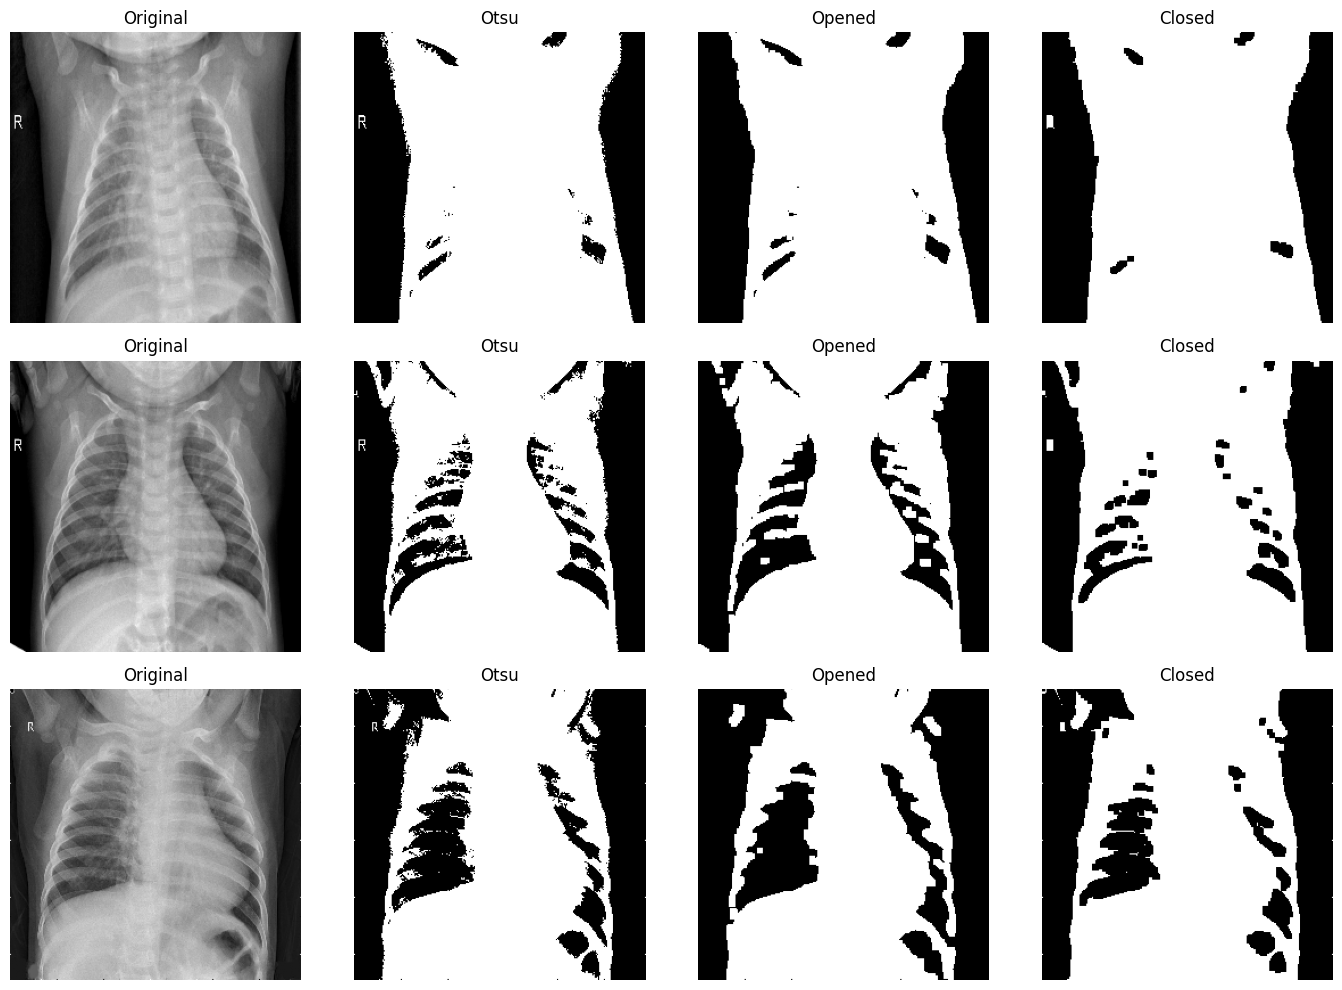

  → Completed Step 2.4



In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(14,10))
for r, path in enumerate(random.sample(sub_paths, 3)):
    img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), target_size)
    _, otsu = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    k = np.ones((3,3), np.uint8)
    opened = cv2.morphologyEx(otsu, cv2.MORPH_OPEN, k, iterations=2)
    closed = cv2.morphologyEx(otsu, cv2.MORPH_CLOSE, k, iterations=2)
    variants = [img, otsu, opened, closed]
    titles = ["Original", "Otsu", "Opened", "Closed"]
    for c, v in enumerate(variants):
        axes[r,c].imshow(v, cmap='gray')
        axes[r,c].set_title(titles[c])
        axes[r,c].axis('off')
plt.tight_layout()
plt.show()
print("  → Completed Step 2.4\n")

---
## **2.5: Defining Feature-Extraction Function**
- **Preprocessing**: Resizes image and applies Otsu thresholding.
- **Shape Features**:
  - Contour area and perimeter
  - Bounding box aspect ratio
  - Compactness = (Perimeter²) / (4π × Area)
- **Texture Features**:
  - Extracted using GLCM (Gray-Level Co-occurrence Matrix)
  - Includes contrast, dissimilarity, homogeneity, energy, correlation


In [ ]:
def extract_feature_vector(path):
    img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), target_size)
    _, thr = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    cnts, _ = cv2.findContours(thr, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = [c for c in cnts if cv2.contourArea(c) > 100]
    cnt = max(cnts, key=cv2.contourArea) if cnts else np.array([[[0,0]],[[256,0]],[[256,256]],[[0,256]]])
    area = cv2.contourArea(cnt)
    peri = cv2.arcLength(cnt, True)
    x,y,w,h = cv2.boundingRect(cnt)
    aspect = w/h if h else 0
    compactness = (peri**2) / (4 * np.pi * area) if area else 0
    glcm = graycomatrix(img, [1], [0], symmetric=True, normed=True)
    texture_features = [graycoprops(glcm, prop)[0,0] for prop in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']]
    return np.array([area, peri, aspect, compactness] + texture_features)
print("  → Completed Step 2.5\n")


  → Completed Step 2.5



---
# **3. Model Training and Evaluation**
## **3.1: Building Feature Matrix & Splitting Dataset**
- **Extracts** feature vectors for all images using a custom function.
- **Scales** features using `StandardScaler` to normalize input values.
- **Splits** the dataset into:
  - 80% training
  - 10% validation
  - 10% testing (stratified to maintain class distribution)
- **Computes** class weights to handle class imbalance in training.


In [ ]:
X = np.vstack([extract_feature_vector(p) for p in sub_paths])
y = np.array(sub_labels)
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)
X_train, X_tmp, y_train, y_tmp = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, stratify=y_tmp, random_state=42)
cw = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), cw))
print(f"  → Data shapes: train={X_train.shape}, val={X_val.shape}, test={X_test.shape}")
print(f"  → Class weights: {class_weight_dict}\n")
print("  → Completed Step 3.1\n")


  → Data shapes: train=(4172, 9), val=(522, 9), test=(522, 9)
  → Class weights: {np.int64(0): np.float64(1.9440820130475303), np.int64(1): np.float64(0.6731203614069055)}

  → Completed Step 3.1



---
## **3.2: Training ML Models**
- **Models Used**:
  - SVM (linear kernel)
  - Random Forest
  - K-Nearest Neighbors
  - Logistic Regression


In [ ]:
models = {
    'SVM': SVC(kernel='linear', class_weight=class_weight_dict, probability=True),
    'RandomForest': RandomForestClassifier(class_weight=class_weight_dict),
    'KNN': KNeighborsClassifier(),
    'LogisticRegression': LogisticRegression(class_weight=class_weight_dict, max_iter=500)
}
results = {}

print("  → ML Models:")
for name, model in models.items():
    model.fit(X_train, y_train)
    val_acc = model.score(X_val, y_val)
    test_acc = model.score(X_test, y_test)
    print(f"{name}\nval acc={val_acc:.3f}\ntest acc={test_acc:.3f}\n")
    results[name+'_val'] = val_acc
    results[name+'_test'] = test_acc

  → ML Models:
SVM
val acc=0.872
test acc=0.875

RandomForest
val acc=0.887
test acc=0.902

KNN
val acc=0.891
test acc=0.902

LogisticRegression
val acc=0.881
test acc=0.877



## **3.3 Model Traning - ANN**

- **ANN Architecture**:
  - Dense(128, ReLU) → Dropout(0.3)
  - Dense(64, ReLU) → Dropout(0.3)
  - Dense(2, Softmax)

- **Training Details**:
  - Optimizer: Adam
  - Loss: Categorical Crossentropy
  - Batch size: 32, Epochs: 50
  - EarlyStopping with `patience=5`
  - Class weighting applied

In [ ]:
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)
y_test_cat = to_categorical(y_test)

ann = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')
])

# compiling model
ann.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# defining early stopping mechanism
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training the model
history = ann.fit(X_train, y_train_cat, validation_data=(X_val, y_val_cat),
                  epochs=50, batch_size=32, class_weight=class_weight_dict,
                  callbacks=[es], verbose=1)

# Evaluation
val_acc = ann.evaluate(X_val, y_val_cat, verbose=0)[1]
test_acc = ann.evaluate(X_test, y_test_cat, verbose=0)[1]
print(f"    ANN: val acc={val_acc:.3f}, test acc={test_acc:.3f}")
results['ANN_val'] = val_acc
results['ANN_test'] = test_acc

Epoch 1/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.7801 - loss: 0.4638 - val_accuracy: 0.8602 - val_loss: 0.3299
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8688 - loss: 0.3177 - val_accuracy: 0.8678 - val_loss: 0.3137
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8695 - loss: 0.3202 - val_accuracy: 0.8716 - val_loss: 0.3126
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8740 - loss: 0.3047 - val_accuracy: 0.8716 - val_loss: 0.3077
Epoch 5/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8748 - loss: 0.3023 - val_accuracy: 0.8736 - val_loss: 0.3060
Epoch 6/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8775 - loss: 0.2938 - val_accuracy: 0.8697 - val_loss: 0.3134
Epoch 7/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8767 - loss: 0.2922 - val_accuracy: 0.8755 - val_loss: 0.3034
Epoch 8/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8745 - loss: 0.2922 - val_accuracy: 0

## **3.4 Accuracy Comparison - All Models**


In [ ]:
print("\n=== Final Comparison ===\n")
for k, v in results.items():
    print(f"  {k}: {v:.3f}")



=== Final Comparison ===

  SVM_val: 0.872
  SVM_test: 0.875
  RandomForest_val: 0.887
  RandomForest_test: 0.902
  KNN_val: 0.891
  KNN_test: 0.902
  LogisticRegression_val: 0.881
  LogisticRegression_test: 0.877
  ANN_val: 0.883
  ANN_test: 0.895


## **3.5 ANN Training Curves**
This code visualizes the training and validation performance of the Artificial Neural Network (ANN) over epochs:

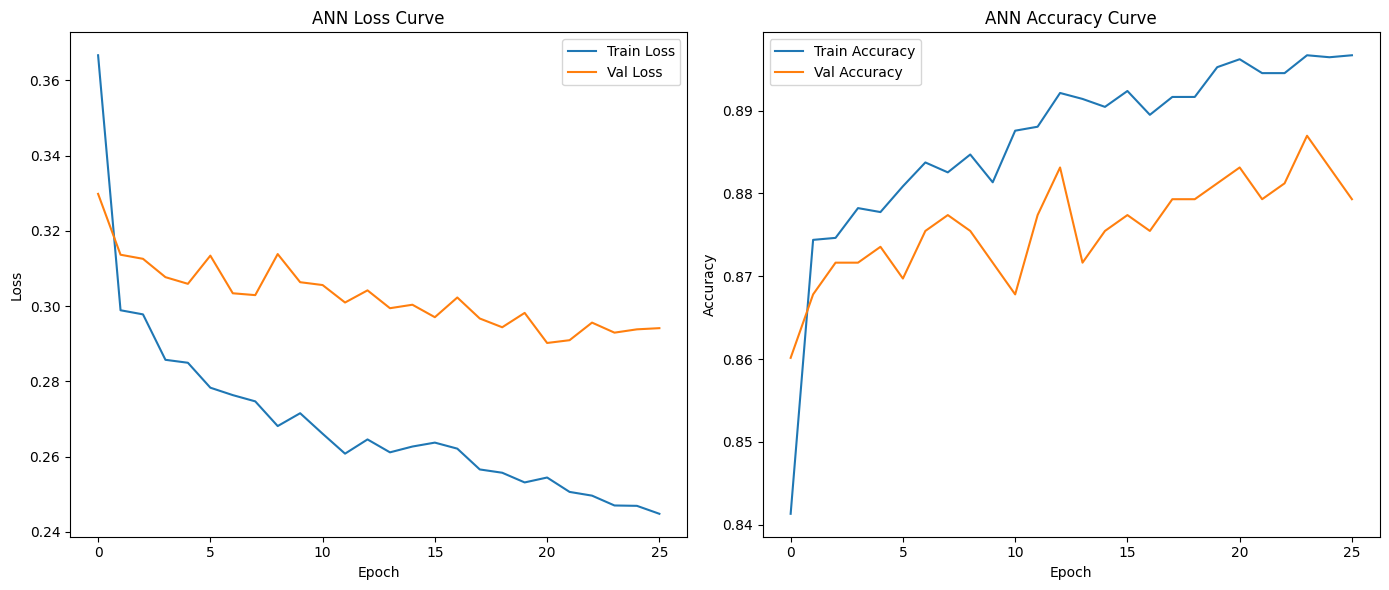

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot Loss Curve
axes[0].plot(history.history['loss'], label='Train Loss')
axes[0].plot(history.history['val_loss'], label='Val Loss')
axes[0].set_title('ANN Loss Curve')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Plot Accuracy Curve
axes[1].plot(history.history['accuracy'], label='Train Accuracy')
axes[1].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[1].set_title('ANN Accuracy Curve')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


## **3.6 ANN Confusion Matrix & Classification Report**

This section evaluates the trained ANN model on the test set using a confusion matrix and classification report


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


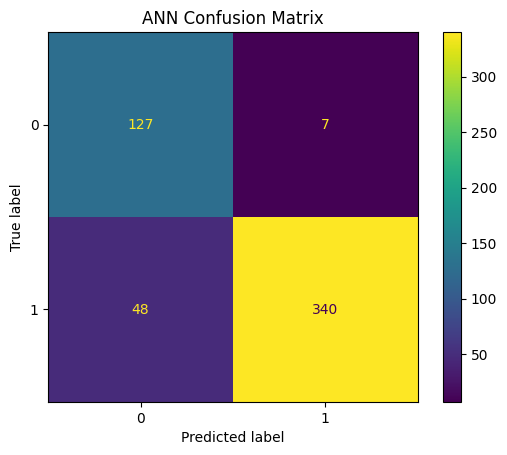

Classification Report for ANN:
              precision    recall  f1-score   support

           0       0.73      0.95      0.82       134
           1       0.98      0.88      0.93       388

    accuracy                           0.89       522
   macro avg       0.85      0.91      0.87       522
weighted avg       0.91      0.89      0.90       522



In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

# Example for ANN:
y_pred = np.argmax(ann.predict(X_test), axis=1)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title('ANN Confusion Matrix')
plt.show()

print("Classification Report for ANN:")
print(classification_report(y_test, y_pred))


## **3.7 Saving the Model**

In [ ]:
# Save the trained model
ann.save('ann_model.keras')
print("Model saved successfully!")


Model saved successfully!


---
---

# **Summary**
- Built a **classical ML pipeline** for pneumonia detection without deep CNNs.
- Applied **image preprocessing**: enhancement, filtering, segmentation, and feature extraction.
- Compared **SVM, Random Forest, KNN, Logistic Regression**, and **ANN**.
- Achieved **strong validation and test accuracies**.
- Gained insights into model performance for medical image classification.

---
---

## **Demonstration: Manual Testing**

Saving person30_virus_69.jpeg to person30_virus_69.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
Predicted class: Pneumonia (confidence = 0.857)


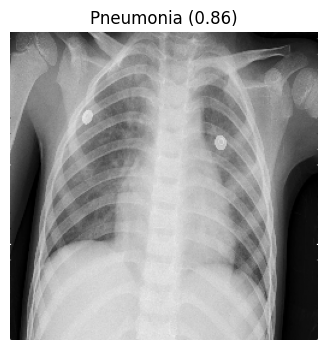

In [88]:
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the saved ANN
ann = load_model('ann_model.keras')

# 1) Upload one image
uploaded = files.upload()
img_path = next(iter(uploaded.keys()))

# 2) Preprocess & extract features (reuse your training function)
fv = extract_feature_vector(img_path)            # produces shape (9,)

# 3) Scale with the same scaler fitted during training
fv_scaled = scaler.transform(fv.reshape(1, -1))   # shape (1, 9)

# 4) Predict with the loaded ANN
probs = ann.predict(fv_scaled)[0]                 # e.g. array([prob_normal, prob_pneumonia])
pred_idx = np.argmax(probs)
classes = ["Normal", "Pneumonia"]
pred_class = classes[pred_idx]
pred_prob = probs[pred_idx]

# 5) Print the result
print(f"Predicted class: {pred_class} (confidence = {pred_prob:.3f})")

# 6) Display the uploaded image
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(4,4))
plt.imshow(cv2.resize(img, target_size), cmap='gray')
plt.title(f"{pred_class} ({pred_prob:.2f})")
plt.axis('off')
plt.show()
